In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Higgs.tools import ImplementationUtils as impl

# WH

Download the data from the HB5 repository and filter out the mass values that are pure interpolations.

/home/jonasw/Projects/HB++/.venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


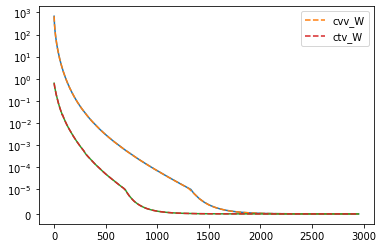

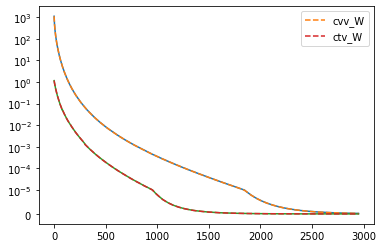

In [21]:
dfW13 = impl.read_csv_from_web(
    "https://gitlab.com/higgsbounds/higgsbounds/-/raw/master/data/Theory_tables/VH_coefficients/LHC13__coefficients_WH_NOEW.dat",
    sep=r"\s+",
    index_col=False,
)
dfW8 = impl.read_csv_from_web(
    "https://gitlab.com/higgsbounds/higgsbounds/-/raw/master/data/Theory_tables/VH_coefficients/LHC8__coefficients_WH_NOEW.dat",
    sep=r"\s+",
    index_col=False,
)
for df in (dfW8, dfW13):
    df.rename(columns={"mh": "m"}, inplace=True)
    df.set_index("m", inplace=True)

wh_nnlo = ["cvv_W", "ctv_W"]
assert np.allclose(dfW13.index, dfW8.index)
# find the relevent grid entries for WH
irW = impl.relevantGridEntries(
    dfW13.index.values,
    np.concatenate((dfW13[wh_nnlo].values, dfW8[wh_nnlo].values), axis=1),
)

for dfW in (dfW8, dfW13):
    plt.figure()
    for value in wh_nnlo:
        plt.plot(dfW.index, dfW[value])
        plt.plot(dfW.iloc[irW].index, dfW.iloc[irW][value], ls="--", label=value)
    plt.yscale("symlog", linthresh=1e-5)
    plt.legend()
    plt.show()

dfW8 = dfW8.iloc[irW]
dfW13 = dfW13.iloc[irW]

# ZH

Same as for WH, download the data from the HB5 repo and determine the relevant entries.

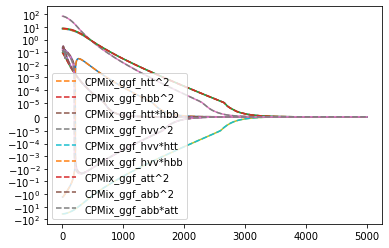

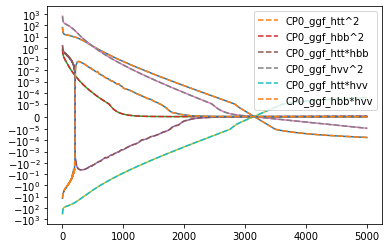

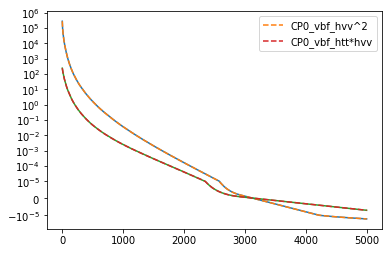

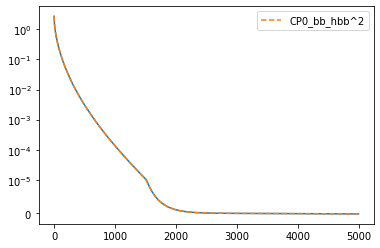

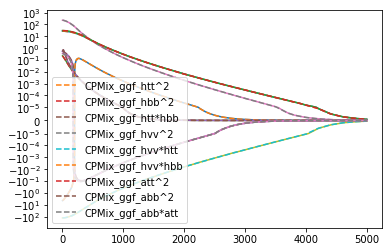

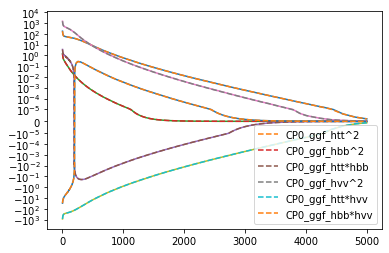

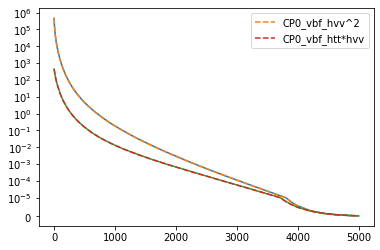

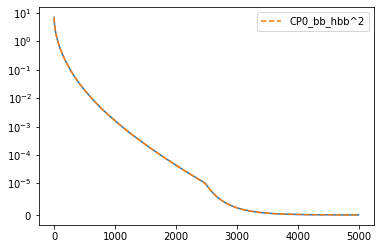

In [8]:
dfZ13 = impl.read_csv_from_web(
    "https://gitlab.com/higgsbounds/higgsbounds/-/raw/master/data/Theory_tables/VH_coefficients/LHC13_fulltable.dat",
    sep=r"\s+",
)

dfZ8 = impl.read_csv_from_web(
    "https://gitlab.com/higgsbounds/higgsbounds/-/raw/master/data/Theory_tables/VH_coefficients/LHC8_fulltable.dat",
    sep=r"\s+",
)

for df in (dfZ8, dfZ13):
    df.rename(columns={"#m0": "m"}, inplace=True)
    df.set_index("m", inplace=True)

assert np.allclose(dfZ13.index, dfZ8.index)
# define the ZH categories
# some of the NLO tables are not used, as they would
# always cancel according to (11) in the HB5 manual

## gg induced Cp-mixed @NLO
gg_nlo = [
    "CPMix_ggf_htt^2",
    "CPMix_ggf_hbb^2",
    "CPMix_ggf_htt*hbb",
    "CPMix_ggf_hvv^2",
    "CPMix_ggf_hvv*htt",
    "CPMix_ggf_hvv*hbb",
    "CPMix_ggf_att^2",
    "CPMix_ggf_abb^2",
    "CPMix_ggf_abb*att",
]

# gg induced CP-even @NNLO
gg_nnlo = [
    "CP0_ggf_htt^2",
    "CP0_ggf_hbb^2",
    "CP0_ggf_htt*hbb",
    "CP0_ggf_hvv^2",
    "CP0_ggf_htt*hvv",
    "CP0_ggf_hbb*hvv",
]

# qq induced CP-mixed @NLO, since there is no CP-odd part, these are irrelevant
qq_nlo = [
    x
    for x in (
        "CPMix_vbf_htt^2",
        "CPMix_vbf_hbb^2",
        "CPMix_vbf_htt*hbb",
        "CPMix_vbf_hvv^2",
        "CPMix_vbf_hvv*htt",
        "CPMix_vbf_hvv*hbb",
        "CPMix_vbf_att^2",
        "CPMix_vbf_abb^2",
        "CPMix_vbf_abb*att",
    )
    if np.any(dfZ13[x])
]
# qq induced CP-even @NNLO
qq_nnlo = [
    x
    for x in (
        "CP0_vbf_htt^2",
        "CP0_vbf_hbb^2",
        "CP0_vbf_hvv^2",
        "CP0_vbf_htt*hvv",
        "CP0_vbf_hbb*hvv",
        "CP0_vbf_htt*hbb",
    )
    if np.any(dfZ13[x])
]

# bb induced CP-mixed @NLO, since the scaling is with |kappa|^2 the CP-even NNLO is used instead
bb_nlo = ["CPMix_bb_hbb^2"]
assert np.allclose(dfZ13["CPMix_bb_hbb^2"], dfZ13["CPMix_bb_abb^2"])
assert np.allclose(dfZ8["CPMix_bb_hbb^2"], dfZ8["CPMix_bb_abb^2"])
# bb induced CP-even @NNLO
bb_nnlo = ["CP0_bb_hbb^2"]

# find the relevant grid entries for ZH
allZHCats = gg_nlo + gg_nnlo + qq_nnlo + bb_nnlo
irZ = impl.relevantGridEntries(
    dfZ13.index.values,
    np.concatenate(
        (dfZ13[allZHCats].values, dfZ8[allZHCats].values),
        axis=1,
    ),
)

for dfZ in (dfZ8, dfZ13):
    for values in [gg_nlo, gg_nnlo, qq_nnlo, bb_nnlo]:
        plt.figure()
        for value in values:
            plt.plot(dfZ.index, dfZ[value])
            plt.plot(dfZ.iloc[irZ].index, dfZ.iloc[irZ][value], ls="--", label=value)
        plt.yscale("symlog", linthresh=1e-5)
        plt.legend()
        plt.show()

dfZ8 = dfZ8.iloc[irZ]
dfZ13 = dfZ13.iloc[irZ] 


# Check WH against YR4 numbers

Check that our cxn values for a CP-even SM-like Higgs lie within the uncertainty band of the YR4 numbers

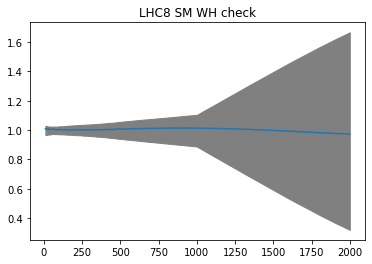

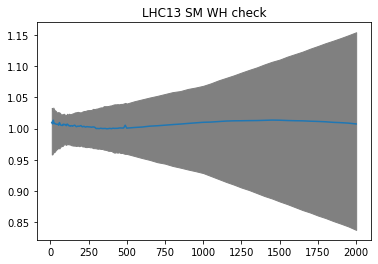

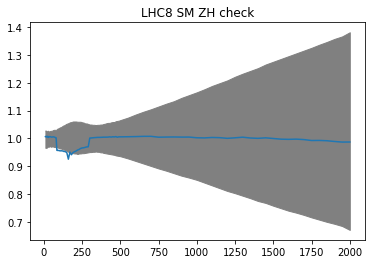

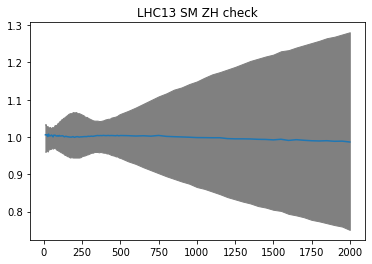

In [88]:
from scipy.interpolate import interp1d

lhc8_BSM_YR4 = pd.read_excel(
    "https://twiki.cern.ch/twiki/pub/LHCPhysics/LHCHWG/Higgs_XSBR_YR4_update.xlsx",
    header=[1, 2],
    sheet_name="YR4 BSM 8TeV",
    skiprows=[3, 4],
    skipfooter=2,
)
lhc13_BSM_YR4 = pd.read_excel(
    "https://twiki.cern.ch/twiki/pub/LHCPhysics/LHCHWG/Higgs_XSBR_YR4_update.xlsx",
    header=[1, 2],
    sheet_name="YR4 BSM 13TeV",
    skiprows=[3, 4],
    skipfooter=2,
)


newCxn = interp1d(dfW8.index, np.sum(dfW8[wh_nnlo], axis=1))
plt.figure()
plt.title("LHC8 SM WH check")
plt.plot(lhc8_BSM_YR4.WH.MH, newCxn(lhc8_BSM_YR4.WH.MH) / lhc8_BSM_YR4.WH.Cross)
plt.fill_between(
    lhc8_BSM_YR4.WH.MH,
    (1 + lhc8_BSM_YR4.WH["Uncertainty"] / 100 + lhc8_BSM_YR4.WH["Uncertainty.2"] / 100),
    (
        1
        + lhc8_BSM_YR4.WH["Uncertainty.1"] / 100
        - lhc8_BSM_YR4.WH["Uncertainty.2"] / 100
    ),
    color="gray",
)
plt.show()

newCxn = interp1d(dfW13.index, np.sum(dfW13[wh_nnlo], axis=1))
plt.figure()
plt.title("LHC13 SM WH check")
plt.plot(lhc13_BSM_YR4.WH.MH, newCxn(lhc13_BSM_YR4.WH.MH) / lhc13_BSM_YR4.WH.Cross)
plt.fill_between(
    lhc13_BSM_YR4.WH.MH,
    (
        1
        + lhc13_BSM_YR4.WH["Uncertainty"] / 100
        + lhc13_BSM_YR4.WH["Uncertainty.2"] / 100
    ),
    (
        1
        + lhc13_BSM_YR4.WH["Uncertainty.1"] / 100
        - lhc13_BSM_YR4.WH["Uncertainty.2"] / 100
    ),
    color="gray",
)
plt.show()


def parsePMUncertainty(x):
    if x is not np.nan:
        return float(x[1:])
    return x


lhc8_BSM_YR4.loc[:, ("ZH", "Uncertainty.2")] = lhc8_BSM_YR4[
    "ZH", "Uncertainty.2"
].apply(parsePMUncertainty)

newCxn = interp1d(dfZ8.index, np.sum(dfZ8[gg_nnlo + qq_nnlo + bb_nnlo], axis=1) * 1e-3)
plt.figure()
plt.title("LHC8 SM ZH check")
plt.plot(lhc8_BSM_YR4.ZH.MH, newCxn(lhc8_BSM_YR4.ZH.MH) / lhc8_BSM_YR4.ZH.Cross)
plt.fill_between(
    lhc8_BSM_YR4.ZH.MH,
    (1 + lhc8_BSM_YR4.ZH["Uncertainty"] / 100 + lhc8_BSM_YR4.ZH["Uncertainty.2"] / 100),
    (
        1
        + lhc8_BSM_YR4.ZH["Uncertainty.1"] / 100
        - lhc8_BSM_YR4.ZH["Uncertainty.2"] / 100
    ),
    color="gray",
)
plt.show()


newCxn = interp1d(
    dfZ13.index, np.sum(dfZ13[gg_nnlo + qq_nnlo + bb_nnlo], axis=1) * 1e-3
)
plt.figure()
plt.title("LHC13 SM ZH check")
plt.plot(lhc13_BSM_YR4.ZH.MH, newCxn(lhc13_BSM_YR4.ZH.MH) / lhc13_BSM_YR4.ZH.Cross)
plt.fill_between(
    lhc13_BSM_YR4.ZH.MH,
    (
        1
        + lhc13_BSM_YR4.ZH["Uncertainty"] / 100
        + lhc13_BSM_YR4.ZH["Uncertainty.2"] / 100
    ),
    (
        1
        + lhc13_BSM_YR4.ZH["Uncertainty.1"] / 100
        - lhc13_BSM_YR4.ZH["Uncertainty.2"] / 100
    ),
    color="gray",
)
plt.show()


# Export to C++ file

In [26]:
from helpers import *

with cppDataFile(
    "../src/predictions/data/VHTables.cpp", scriptname="tools/transferVHCxns.ipynb"
) as cppf:
    cppf.write("const auto whGrid = ")
    cppf.write(grid2CppString([dfW8.index.values]))
    for e, df in zip((8, 13), (dfW8, dfW13)):
        cppf.write("const auto lhc{}WHN2lo = ".format(e))
        cppf.write(values2CppString(df[wh_nnlo].values))

    # the ZH cross sections in the old tables were in fb, so divide by 1e3 everywhere
    cppf.write("const auto zhGrid = ")
    cppf.write(grid2CppString([dfZ8.index.values]))
    for e, df in zip((8, 13), (dfZ8, dfZ13)):
        cppf.write("const auto lhc{e}ggZHNlo = ".format(e=e))
        cppf.write(values2CppString(df[gg_nlo].values / 1e3))

        cppf.write("const auto lhc{e}ggZHN2lo = ".format(e=e))
        cppf.write(values2CppString(df[gg_nnlo].values / 1e3))

        cppf.write("const auto lhc{e}qqZHN2lo = ".format(e=e))
        cppf.write(values2CppString(df[qq_nnlo].values / 1e3))

        assert len(bb_nnlo) == 1
        cppf.write("const auto lhc{e}bbZHN2lo = ".format(e=e))
        cppf.write(values2CppString(df[bb_nnlo[0]].values / 1e3))
